# Prepocessing and data selection 

In [1]:
from GG_mthesis import *
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [3]:
# sns.set_style('whitegrid')
# sns.set_palette('colorblind')
# sns.set(font_scale=1.2)

## Reshaping

In [4]:
#define the path
path = '.\\data\\01_raw\\JR17001\\b1903933.nc'

#open the dataset with the defined path
ds_orig = xr.open_dataset(path) 

#Squeeze eliminates dimensions of length 0 and 1. Drop REFMAX as it is not needed. Swap MAXT (count) with TIME 
#to make TIME unique dimension (MAXT is a count a not needed, you can access the same with .isel). Rename coords to
#my standard.
ds = ds_orig.squeeze().drop_dims('REFMAX').swap_dims({'MAXT':'TIME'}).rename({
    'LONGITUDE':'lon','LATITUDE':'lat','TIME':'time','DEPTH':'depth'})

#Definition of new time attributes (datetime). Retrieved from original dataset and modified.
new_time_attr = {'long_name': 'Chronological DateTime Date',
 'standard_name': 'time',
 'ancillary_variables': 'TIME_SEADATANET_QC',
 'axis': 'T',
 'valid_min': 0.0,
 'valid_max': 2500000.0,
 'sdn_parameter_urn': 'SDN:P01::CJDY1101',
 'sdn_parameter_name': 'DateTime (chronological)',
 'sdn_uom_name': 'Days',
 'sdn_uom_urn': 'SDN:P06::UTAA'}

#Pull out the index (a CFTimeIndex) and use built in to_datetimeindex method.
datetimeindex = ds.indexes['time'].to_datetimeindex()

#Replace CFTimeIndex with DateTimeIndex:
ds['time'] = datetimeindex

#Attach new attributes
ds['time'].attrs = new_time_attr

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\xarray\coding\times.py:174: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
C:\Users\gian_\AppData\Local\Temp/ipykernel_13900/4175495341.py:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


## Bathmetry - data selection

In [5]:
etopo1 = xr.open_dataset(r'data/01_raw/ETOPO1_Bed_g_gmt4.grd',engine='netcdf4')

In [6]:
etopo1 = etopo1.sel(x=slice(-62,-52), y=slice(-64,-52))

In [7]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [8]:
ds_ACC_fronts = xr.load_dataset(r'data\03_processed\geo_fronts\park\62985.nc')

In [9]:
def sel_Park_region(dataset):
    data_lat = [
        dataset['LatNB'].values,
        dataset['LatSAF'].values,
        dataset['LatPF'].values,
        dataset['LatSACCF'].values,
        dataset['LatSB'].values,
    ]

    data_lon = [
        dataset['LonNB'].values,
        dataset['LonSAF'].values,
        dataset['LonPF'].values,
        dataset['LonSACCF'].values,
        dataset['LonSB'].values,
    ]

    index_front = ['NB', 'SAF', 'PF', 'SACCF', 'SB']


    df_fronts = pd.DataFrame(columns=['longitude','latitude','front'])
    for i in range(5):
        df_aux = pd.DataFrame({'longitude':data_lon[i], 'latitude':data_lat[i],'front':index_front[i]})
        df_fronts = df_fronts.append(df_aux)
    df_fronts = df_fronts.reset_index(drop=True)

    df_fronts_sel = df_fronts.where(
        (df_fronts['longitude'] > -62) & 
        (df_fronts['longitude'] < -52) & 
        (df_fronts['latitude'] > -62) & 
        (df_fronts['latitude'] < -52)
        ).dropna().reset_index()
    df_front_sel = df_fronts_sel.set_index(['front',df_fronts_sel.index]).drop('index',1)
    return df_front_sel

In [10]:
df_front_sel = sel_Park_region(ds_ACC_fronts)

C:\Users\gian_\AppData\Local\Temp/ipykernel_13900/662591249.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_front_sel = df_fronts_sel.set_index(['front',df_fronts_sel.index]).drop('index',1)


In [11]:
df = ds.to_dataframe()

df = df.where(
    (df['lon'] > -62) & 
     (df['lon'] < -52) & 
     (df['lat'] > -60.4) & 
     (df['lat'] < -55)).dropna(how='all')

In [12]:
def plot_region(bath, fronts, data):
    import cmocean.cm as cm
    from matplotlib.cm import ScalarMappable

    fig= plt.figure(figsize=(14,12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-62,-52,-62,-52])
    x = bath.x
    y = bath.y
    z = bath.z
    vmin = z.min()
    vmax = z.max()
    topo_f = ax.contourf(x, y, z, 
                    cmap = cm.deep_r,
                        vmin = vmin,
                        vmax = 0,
                    #    norm=MidpointNormalize(
                    #        midpoint=-1000,
                    #        vmin=vmin,lines
                    #        vmax=0
                    #     ),
                    levels=20
                    )
    plt.colorbar(ScalarMappable(norm=topo_f.norm, cmap=topo_f.cmap), pad=0.02)

    # topo = ax.contour(x, y, z, 
    #                   colors = 'black',
    #                 #    vmin = vmin,
    #                    levels=[-5500,-4500,-3000,-1500]
    #                    )
    #ax.clabel(topo)

    ax.coastlines(zorder=100)
    ax.add_feature(cartopy.feature.LAND, color='green', zorder=50)
    gl = ax.gridlines(draw_labels=True, linestyle='-.', color='gray')
    gl.xlabels_top = False
    gl.ylabels_right = False

    scat = ax.scatter(data['lon'], data['lat'], c=data.index, cmap='autumn', s=2)
    cbar = plt.colorbar(scat, location='bottom', pad=0.05, ax=ax)
    cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)

    s=4
    SAF = ax.plot(fronts.loc['SAF']['longitude'], fronts.loc['SAF']['latitude'],transform=ccrs.PlateCarree(), label='SAF_Park', color='purple')#, s=s)
    PF = ax.plot(fronts.loc['PF']['longitude'], fronts.loc['PF']['latitude'], transform=ccrs.PlateCarree(), label='PF_Park', color='black')#, s=s)
    SACCF = ax.plot(fronts.loc['SACCF']['longitude'], fronts.loc['SACCF']['latitude'],transform=ccrs.PlateCarree(), label='SACCF_Park', color='yellow')#, s=s)
    NB = ax.plot(fronts.loc['NB']['longitude'], fronts.loc['NB']['latitude'],transform=ccrs.PlateCarree(), label='NB_Park', color='red')#, s=s)
    SB = ax.plot(fronts.loc['SB']['longitude'], fronts.loc['SB']['latitude'],transform=ccrs.PlateCarree(), label='SB_Park', color='red')#, s=s)

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gian_\AppData\Local\Temp/ipykernel_13900/2286266918.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)


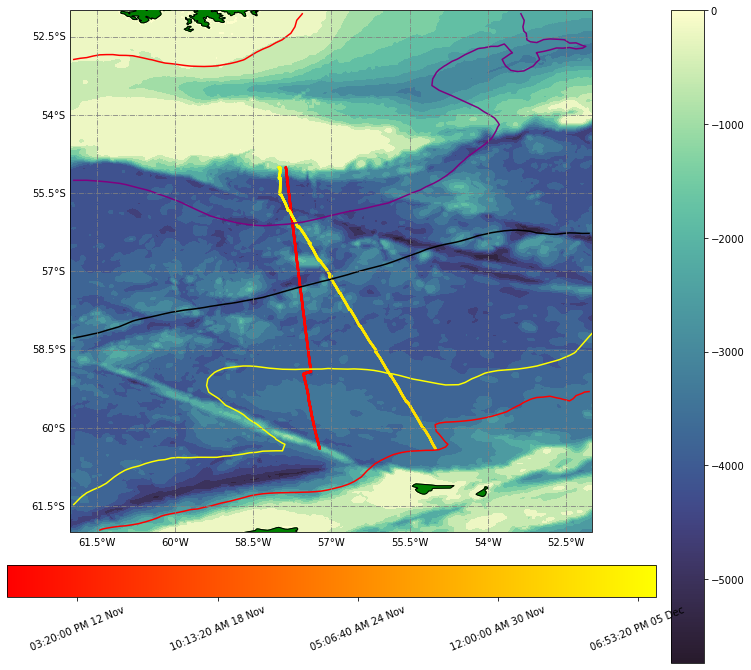

In [13]:
plot_region(etopo1, df_front_sel, df)

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gian_\AppData\Local\Temp/ipykernel_13900/2286266918.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)


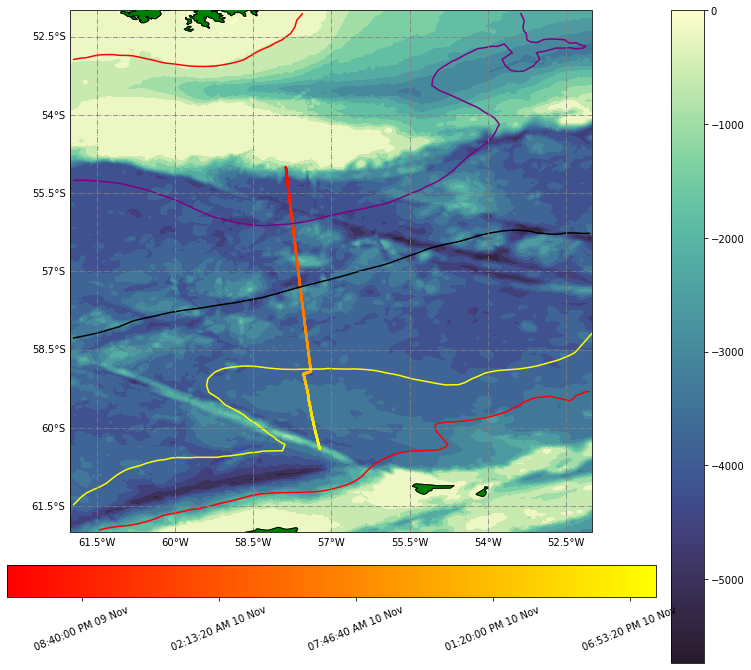

In [14]:
df_sel_1 = df.loc['2017-11-09 00':'2017-11-20 00']
plot_region(etopo1, df_front_sel, df_sel_1)

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gian_\AppData\Local\Temp/ipykernel_13900/2286266918.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)


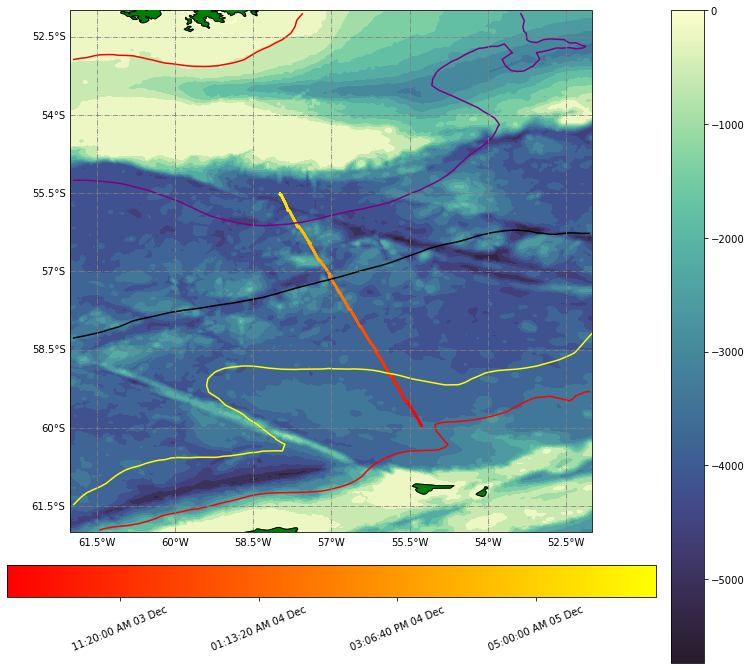

In [15]:
df_sel_2 = df.loc['2017-12-03 00 ':'2017-12-05 16']
plot_region(etopo1, df_front_sel, df_sel_2)

## functions

In [16]:
def QC_count(dataframe):
    position_QC = dataframe['POSITION_SEADATANET_QC'].value_counts()
    depth_QC = dataframe['DEPTH_SEADATANET_QC'].value_counts()
    time_QC = dataframe['TIME_SEADATANET_QC'].value_counts()
    conduc_QC = dataframe['CNDCSG01_SEADATANET_QC'].value_counts()
    PS_uncal_QC = dataframe['PSALSG01_SEADATANET_QC'].value_counts()
    PS_cal_QC = dataframe['PSALSU01_SEADATANET_QC'].value_counts()
    T_hull_QC = dataframe['TEMPHU01_SEADATANET_QC'].value_counts()
    T_tsg_QC = dataframe['TMESSG01_SEADATANET_QC'].value_counts()

    QC =[position_QC, depth_QC, time_QC, conduc_QC, PS_uncal_QC, PS_cal_QC, T_hull_QC, T_tsg_QC]

    df_QC = pd.DataFrame(QC)

    return df_QC

def drop_QC_var(dataframe):
    df = dataframe.drop(['SDN_CRUISE', 'crs', 'SDN_EDMO_CODE', 'SDN_STATION', 'SDN_LOCAL_CDI_ID',
       'SDN_BOT_DEPTH', 'POSITION_SEADATANET_QC', 'depth',
       'DEPTH_SEADATANET_QC', 'TIME_SEADATANET_QC', 'ATTNDR01', 'CPHLUMTF_SEADATANET_QC',
       'CPHLUMTF', 'PSALSG01_SEADATANET_QC', 'PSALSU01_SEADATANET_QC','TMESSG01_SEADATANET_QC'], axis=1)
    return df

def nan_count(dataframe):
    aux = {}
    for var in dataframe.columns:
        index = var
        value = dataframe[var].isna().sum()
        aux[index] = [value]
    return pd.DataFrame(aux, index=['Nan_count']).transpose()

def time_difference(time_array):
    time_dif = []
    for i in range(len(time_array)-1):
        time_dif.append(time_array[i+1] - time_array[i])
    time_dif = np.array(time_dif).astype('timedelta64[s]').astype('float')
    return time_dif

def histograms(vel, distance):
    #Let's plot the distances and vessel speed in a histogram, with a cut-off line at 4ms-1

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))

    ax0.hist(vel, color='grey', alpha = 0.5, bins=30)

    ax0.axvline(x=np.median(vel), label=str(('Median = ') + str(round(np.median(vel),2)) 
        + str(' m')), color='black', linestyle='-.')
    ax0.axvline(x=np.mean(vel), label=str(('Mean = ') + str(round(np.mean(vel),2)) 
        + str(' m')), color='black', linestyle='--')
    ax0.axvline(x=np.quantile(vel, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(vel, .10),2)) 
        + str(' m')), color='black', linestyle=':',)
    ax0.axvline(x=np.quantile(vel, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(vel, .90),2)) 
        + str(' m')), color='black', linestyle=':')
    ax0.legend(loc='upper right')

    ax1.hist(distance, color='grey', alpha =0.5, bins=30)

    ax1.axvline(x=np.median(distance), label=str(('Median = ') + str(round(np.median(distance),2)) 
        + str(' m')), color='black', linestyle='-.')
    ax1.axvline(x=np.mean(distance), label=str(('Mean = ') + str(round(np.mean(distance),2)) 
        + str(' m')), color='black', linestyle='--')
    ax1.axvline(x=np.quantile(distance, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(distance, .10),2)) 
        + str(' m')), color='black', linestyle=':',)
    ax1.axvline(x=np.quantile(distance, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(distance, .90),2)) 
        + str(' m')), color='black', linestyle=':')
    ax1.legend(loc='upper right')

    ax0.axvline(x=2, label='speed cut off = 2ms-1 (120 m)', color='red', linestyle='-')
    ax0.axvline(x=10, label='speed cut off = 10ms-1 (600 m)', color='red', linestyle='-')

    ax1.axvline(x=120, label='speed cut off = 2ms-1 (120 m)', color='red', linestyle='-')
    ax1.axvline(x=600, label='speed cut off = 10ms-1 (600 m)', color='red', linestyle='-')

    #ax1.set_xticks(np.arange(0, 460, 60))

    ax0.set(xlabel='Vessel speed (ms-1)')
    ax1.set(xlabel='Distance (m)')

    ax0.legend(loc='upper right')
    
def stats(**kwargs):
    for i in kwargs:
        print('Min(' + str(i) + '): ' + str(np.min(np.array(kwargs[i]))))
        print('Max(' + str(i) + '): ' + str(np.max(np.array(kwargs[i]))))
        print('Mean(' + str(i) + '): ' + str(np.mean(np.array(kwargs[i]))))
        print('Median(' + str(i) + '): ' + str(np.median(np.array(kwargs[i]))))
        print( )

## df_sel_1

Method: I apply the count_flags function to the QC variables. If they are fine (only good values and interpolated values) drop
it from the dataset (the QC variable).

In [17]:
df_sel_1 = df.loc['2017-11-09 00':'2017-11-20 00']

In [18]:
QC_count(df_sel_1)

,49.0
POSITION_SEADATANET_QC,1578
DEPTH_SEADATANET_QC,1578
TIME_SEADATANET_QC,1578
CNDCSG01_SEADATANET_QC,1578
PSALSG01_SEADATANET_QC,1578
PSALSU01_SEADATANET_QC,1578
TEMPHU01_SEADATANET_QC,1578
TMESSG01_SEADATANET_QC,1578


In [19]:
df_sel_1 = drop_QC_var(df_sel_1)

In [20]:
nan_count(df_sel_1)

,Nan_count
lat,0
lon,0
ATTNDR01_SEADATANET_QC,0
CNDCSG01_SEADATANET_QC,0
CNDCSG01,0
PSALSG01,0
PSALSU01,0
TEMPHU01_SEADATANET_QC,0
TEMPHU01,0
TEMPHU02_SEADATANET_QC,0


In [21]:
#Let's calculate the distances
distance_sel_1 = gsw.distance(df_sel_1['lon'], df_sel_1['lat'])

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance_sel_1), 0, 0)

df_sel_1['distance_cum'] = distance_cum

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


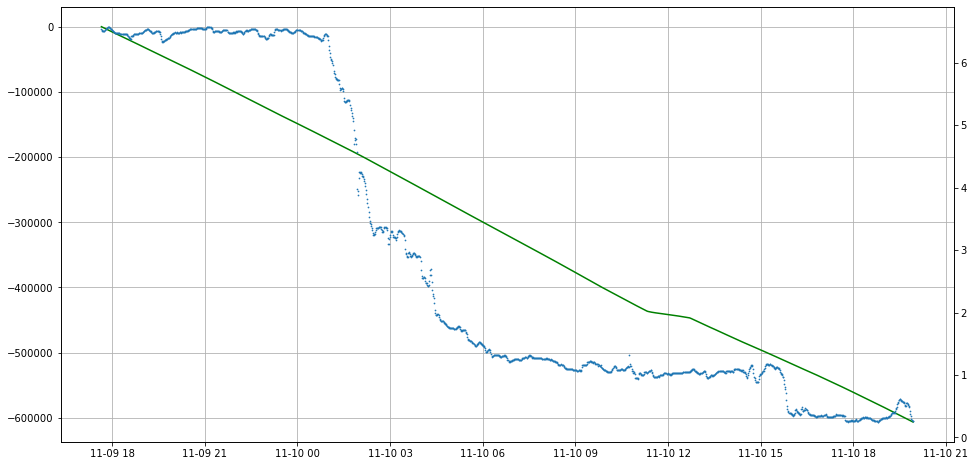

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_sel_1.index, -df_sel_1['distance_cum'], c='green')
ax1 = ax.twinx()
ax1.scatter(df_sel_1.index, df_sel_1['TMESSG01'], s=0.5)
ax.grid(axis='both', which='both')

In [23]:
time_dif_sel_1 = time_difference(df_sel_1.index)

In [24]:
vel_sel_1 = distance_sel_1/time_dif_sel_1

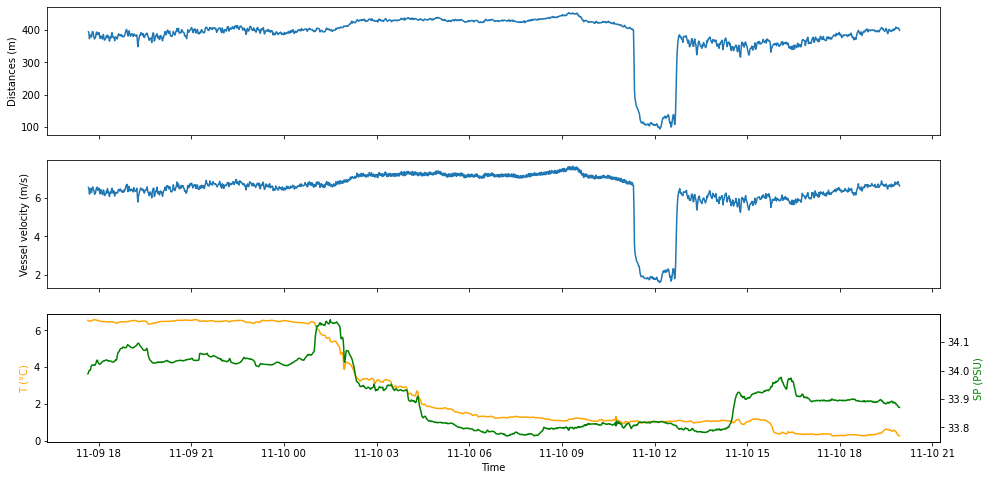

In [25]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax0.plot(df_sel_1.index[1:], distance_sel_1)
ax0.set(ylabel='Distances (m)')

ax1.plot(df_sel_1.index[1:], vel_sel_1)
ax1.set(ylabel='Vessel velocity (m/s)')

ax2.plot(df_sel_1.index, df_sel_1['TMESSG01'], color='orange')
ax2.set(xlabel='Time', ylabel='T (°C)')
ax2.yaxis.label.set_color('orange')
ax3 = ax2.twinx()
ax3.plot(df_sel_1.index, df_sel_1['PSALSU01'], color='green')
ax3.set(ylabel='SP (PSU)')
ax3.yaxis.label.set_color('green')



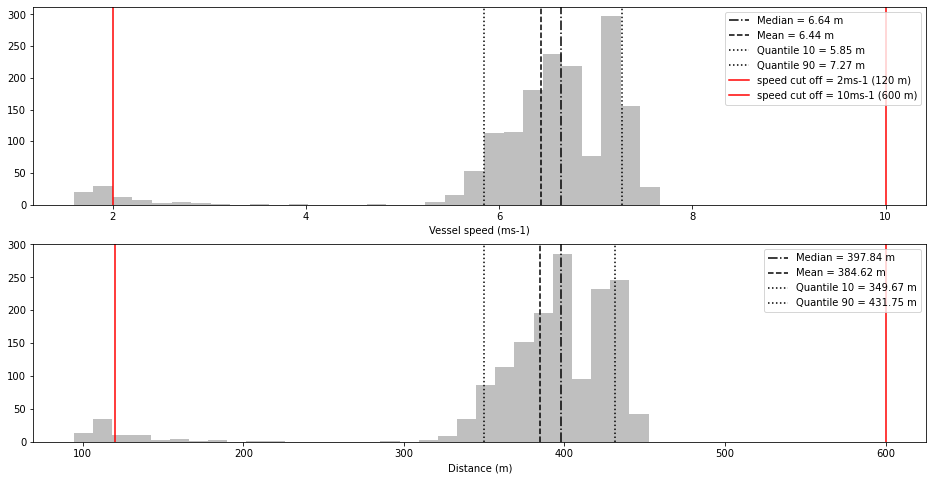

In [26]:
histograms(vel_sel_1, distance_sel_1)

In [27]:
stats(time=time_dif_sel_1, distance=distance_sel_1)

Min(time): 59.0
Max(time): 60.0
Mean(time): 59.742549143944196
Median(time): 60.0

Min(distance): 94.40969626103448
Max(distance): 452.37620203615376
Mean(distance): 384.6176584774934
Median(distance): 397.8445380568028



In [28]:
df_1 = df_sel_1
df_1['distance_aux'] = np.insert(distance_sel_1, 0, -999)
df_1['vel'] = np.insert(vel_sel_1, 0, 5.5)
df_1 = df_1.where(df_1['distance_aux'] > 120)
#df_sel_1 = df_sel_1[df_sel_1['vel'] > 2]
df_1 = df_1.drop('distance_aux', axis=1)

# distance_1 = gsw.distance(df_1['lon'], df_1['lat'])
# distance_cum = np.insert(np.cumsum(distance_1), 0, 0)
# df_1['distance_cum'] = distance_cum

In [29]:
distance_1_aux = gsw.distance(df_1['lon'].dropna(), df_1['lat'].dropna())
# distance_1_aux = distance_1_aux[~np.isnan(distance_1_aux)]

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


In [30]:
time_dif_1_aux = time_difference(df_1.dropna(axis=0).index)

In [31]:
#vel_1 = distance_1/time_dif_1

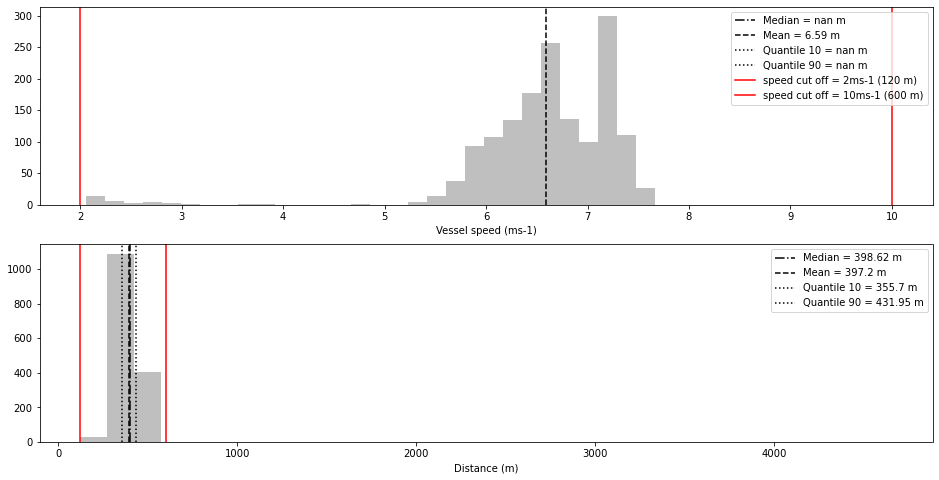

In [32]:
histograms(df_1['vel'], distance_1_aux)

In [33]:
stats(time=time_dif_1_aux/60, distance=distance_1_aux, velocity=df_1['vel'].dropna())

Min(time): 0.9833333333333333
Max(time): 43.0
Mean(time): 1.0284622105723022
Median(time): 1.0

Min(distance): 123.24018580090953
Max(distance): 4658.686640152877
Mean(distance): 397.19751357547386
Median(distance): 398.61676679197797

Min(velocity): 2.0540030966818255
Max(velocity): 7.663398247502152
Mean(velocity): 6.5904460027105145
Median(velocity): 6.661482880314068



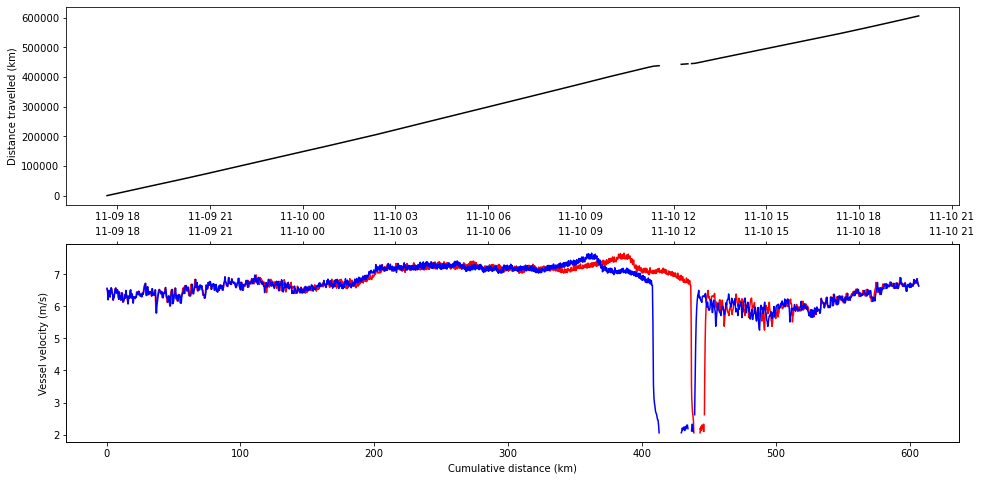

In [34]:
#Let's plot what we have got so far

fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16,8))#, sharex=True)
ax0.plot(df_1.index, df_1['distance_cum'], color='black')
ax0.set(ylabel='Distance travelled (km)')

ax1.plot(df_1['distance_cum']/1000, df_1['vel'], color='red')
ax1.set(xlabel='Cumulative distance (km)', ylabel='Vessel velocity (m/s)')
ax2 = ax1.twiny()
ax2.plot(df_1.index, df_1['vel'], color='blue')


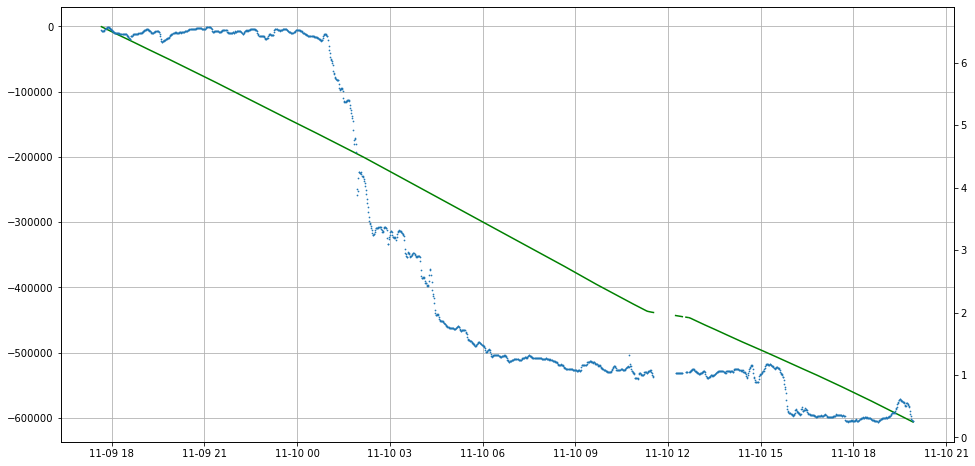

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_1.index, -df_1['distance_cum'], c='green')
ax1 = ax.twinx()
ax1.scatter(df_1.index, df_1['TMESSG01'], s=0.5)
ax.grid(axis='both', which='both')

## df_sel_2

Method: I apply the count_flags function to the QC variables. If they are fine (only good values and interpolated values) drop
it from the dataset (the QC variable).

In [36]:
df_sel_2 = df.loc['2017-12-03 00 ':'2017-12-05 16']

In [37]:
QC_count(df_sel_2)

,49.0
POSITION_SEADATANET_QC,3901
DEPTH_SEADATANET_QC,3901
TIME_SEADATANET_QC,3901
CNDCSG01_SEADATANET_QC,3639
PSALSG01_SEADATANET_QC,3609
PSALSU01_SEADATANET_QC,3609
TEMPHU01_SEADATANET_QC,3604
TMESSG01_SEADATANET_QC,3609


In [38]:
df_sel_2 = drop_QC_var(df_sel_2)

In [39]:
nan_count(df_sel_2)

,Nan_count
lat,0
lon,0
ATTNDR01_SEADATANET_QC,296
CNDCSG01_SEADATANET_QC,262
CNDCSG01,262
PSALSG01,292
PSALSU01,292
TEMPHU01_SEADATANET_QC,297
TEMPHU01,297
TEMPHU02_SEADATANET_QC,297


In [40]:
#Let's calculate the distances
distance_sel_2 = gsw.distance(df_sel_2['lon'], df_sel_2['lat'])

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance_sel_2), 0, 0)

df_sel_2['distance_cum'] = distance_cum

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


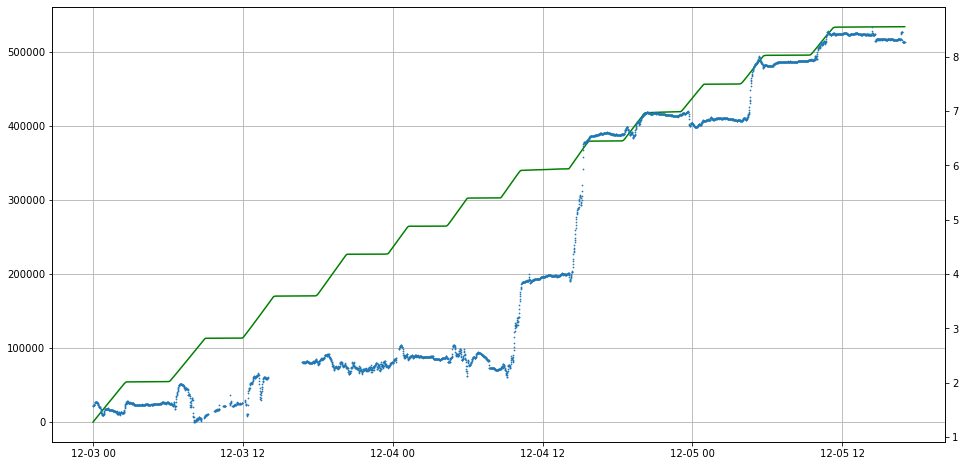

In [41]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_sel_2.index, df_sel_2['distance_cum'], c='green')
ax1 = ax.twinx()
ax1.scatter(df_sel_2.index, df_sel_2['TMESSG01'], s=0.5)
ax.grid(axis='both', which='both')

In [42]:
time_dif_sel_2 = time_difference(df_sel_2.index)

In [43]:
vel_sel_2 = distance_sel_2/time_dif_sel_2

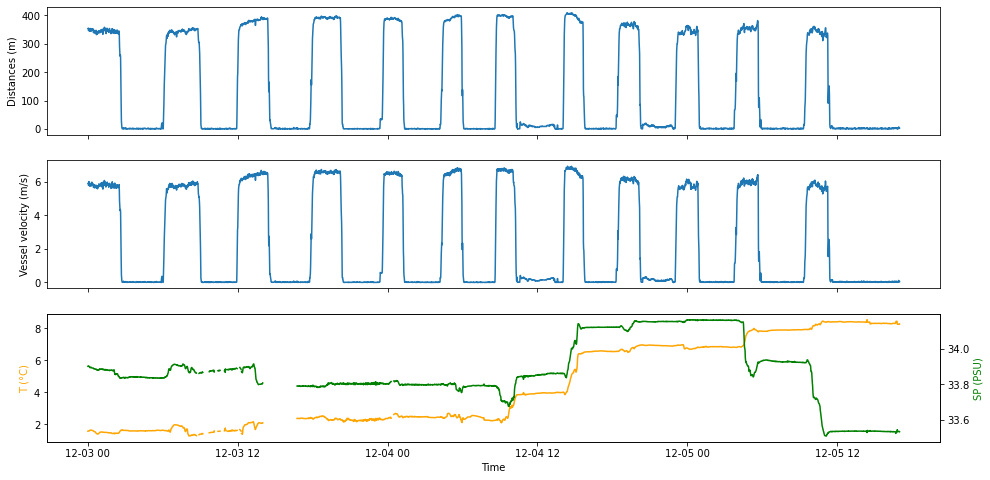

In [44]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
df_plot = df_sel_2
ax0.plot(df_plot.index[1:], distance_sel_2)
ax0.set(ylabel='Distances (m)')

ax1.plot(df_plot.index[1:], vel_sel_2)
ax1.set(ylabel='Vessel velocity (m/s)')

ax2.plot(df_plot.index, df_plot['TMESSG01'], color='orange')
ax2.set(xlabel='Time', ylabel='T (°C)')
ax2.yaxis.label.set_color('orange')
ax3 = ax2.twinx()
ax3.plot(df_plot.index, df_plot['PSALSU01'], color='green')
ax3.set(ylabel='SP (PSU)')
ax3.yaxis.label.set_color('green')

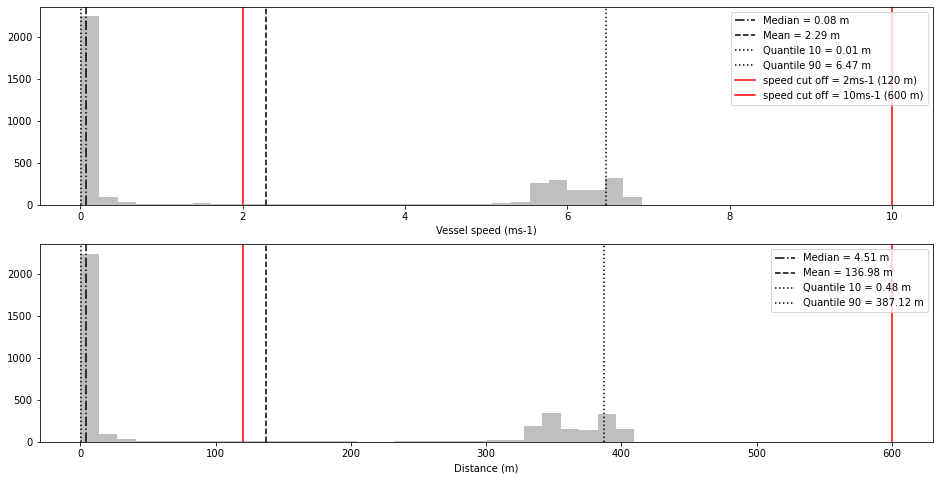

In [45]:
histograms(vel_sel_2, distance_sel_2)

In [46]:
stats(time=time_dif_sel_2, distance=distance_sel_2)

Min(time): 59.0
Max(time): 60.0
Mean(time): 59.72051282051282
Median(time): 60.0

Min(distance): 0.0
Max(distance): 409.6977582723749
Mean(distance): 136.97986683227768
Median(distance): 4.513737589770943



In [47]:
df_2 = df_sel_2
df_2['distance_aux'] = np.insert(distance_sel_2, 0, -999)
df_2['vel'] = np.insert(vel_sel_2, 0, 5.5)
df_2 = df_2.where(df_2['distance_aux'] > 120)
#df_sel_1 = df_sel_1[df_sel_1['vel'] > 2]
df_2 = df_2.drop('distance_aux', axis=1)

# distance_1 = gsw.distance(df_1['lon'], df_1['lat'])
# distance_cum = np.insert(np.cumsum(distance_1), 0, 0)
# df_1['distance_cum'] = distance_cum

In [48]:
distance_2_aux = gsw.distance(df_2['lon'].dropna(), df_2['lat'].dropna())
# distance_1_aux = distance_1_aux[~np.isnan(distance_1_aux)]

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


In [49]:
time_dif_2_aux = time_difference(df_2.dropna(axis=0).index)

In [50]:
#vel_1 = distance_1/time_dif_1

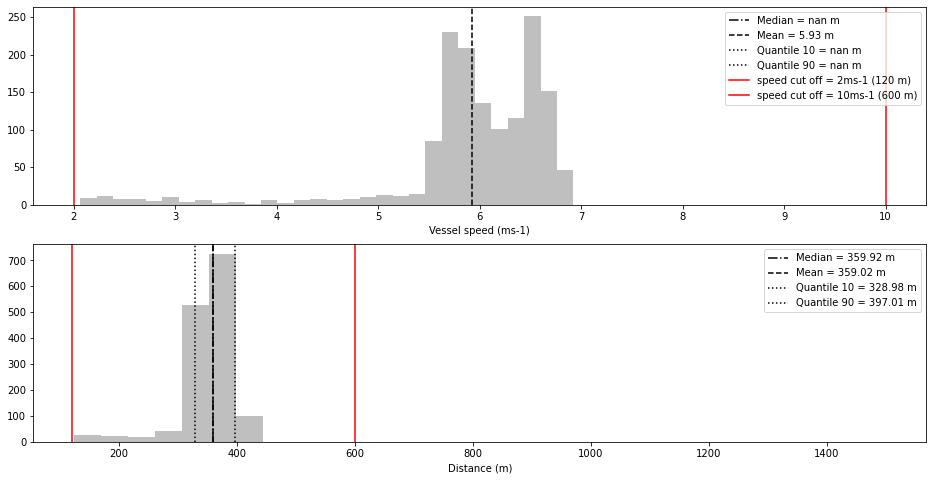

In [51]:
histograms(df_2['vel'], distance_2_aux)

In [52]:
stats(time=time_dif_2_aux/60, distance=distance_2_aux, velocity=df_2['vel'].dropna())

Min(time): 0.9833333333333333
Max(time): 232.0
Mean(time): 2.5285917496443813
Median(time): 1.0

Min(distance): 124.02306373509197
Max(distance): 1499.2207482858237
Mean(distance): 359.02135256459593
Median(distance): 359.9225107982009

Min(velocity): 2.0617749928860665
Max(velocity): 6.923398941831921
Mean(velocity): 5.926986812100629
Median(velocity): 6.0235792835351685



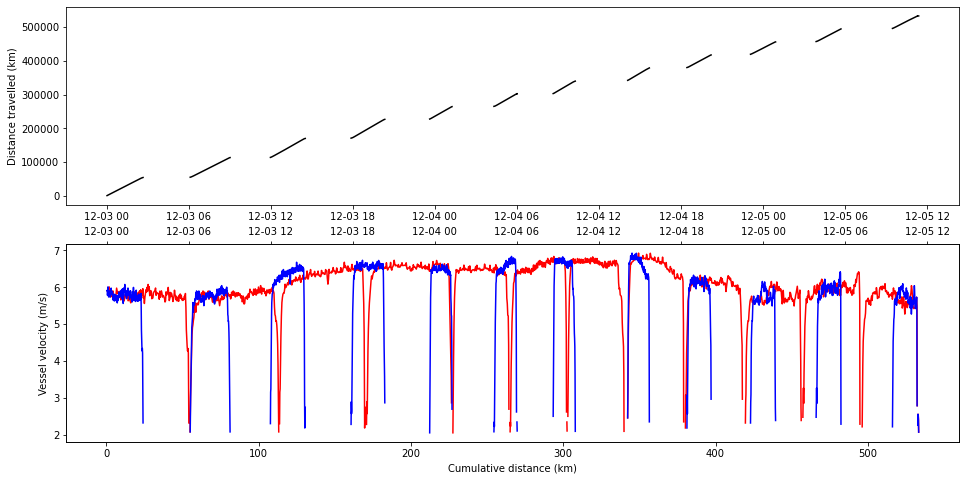

In [53]:
#Let's plot what we have got so far

fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16,8))#, sharex=True)
ax0.plot(df_2.index, df_2['distance_cum'], color='black')
ax0.set(ylabel='Distance travelled (km)')

ax1.plot(df_2['distance_cum']/1000, df_2['vel'], color='red')
ax1.set(xlabel='Cumulative distance (km)', ylabel='Vessel velocity (m/s)')
ax2 = ax1.twiny()
ax2.plot(df_2.index, df_2['vel'], color='blue')


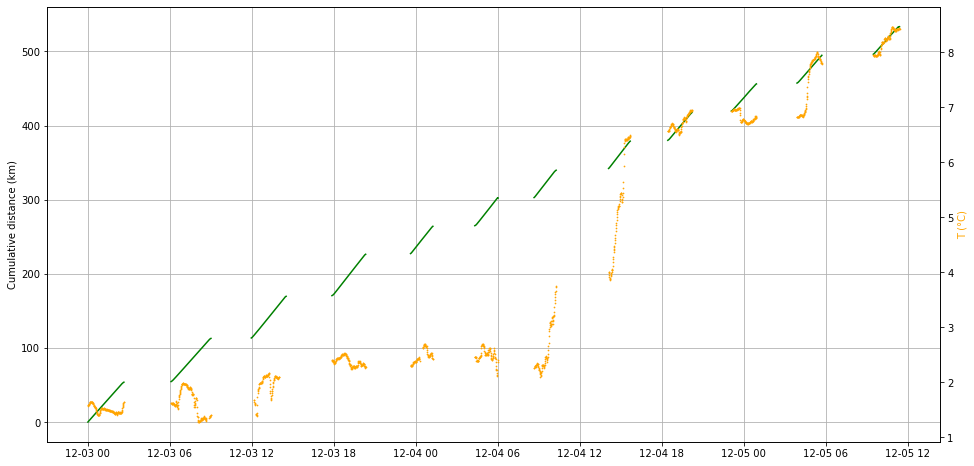

In [54]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot = df_2
ax.plot(df_plot.index, df_plot['distance_cum']/1000, c='green')
ax.set_ylabel('Cumulative distance (km)')
ax1 = ax.twinx()
ax1.scatter(df_plot.index, df_plot['TMESSG01'], s=0.5, c='orange')
ax1.set(xlabel='Time', ylabel='T (°C)')
ax.grid(axis='both', which='both')
ax1.yaxis.label.set_color('orange')

In [55]:
df_2

,lat,lon,ATTNDR01_SEADATANET_QC,CNDCSG01_SEADATANET_QC,CNDCSG01,PSALSG01,PSALSU01,TEMPHU01_SEADATANET_QC,TEMPHU01,TEMPHU02_SEADATANET_QC,TEMPHU02,TMESSG01,distance_cum,vel
time,,,,,,,,,,,,,,
2017-12-03 00:00:00.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-03 00:01:00.000000,-59.960789,-55.270668,49.0,49.0,2.954320,33.899849,33.902950,49.0,0.71590,49.0,0.72765,1.57865,354.519984,5.908666
2017-12-03 00:02:00.000000,-59.957706,-55.272331,49.0,49.0,2.954850,33.899151,33.902248,49.0,0.71705,49.0,0.72795,1.58500,709.538263,5.916971
2017-12-03 00:03:00.000000,-59.954685,-55.273891,49.0,49.0,2.955225,33.900150,33.903252,49.0,0.71730,49.0,0.72650,1.58890,1056.531822,5.783226
2017-12-03 00:04:00.000000,-59.951633,-55.275494,49.0,49.0,2.955855,33.898602,33.901699,49.0,0.72330,49.0,0.73575,1.59805,1407.400422,5.847810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-05 16:56:00.000224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 16:57:00.001024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-05 16:58:00.001824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


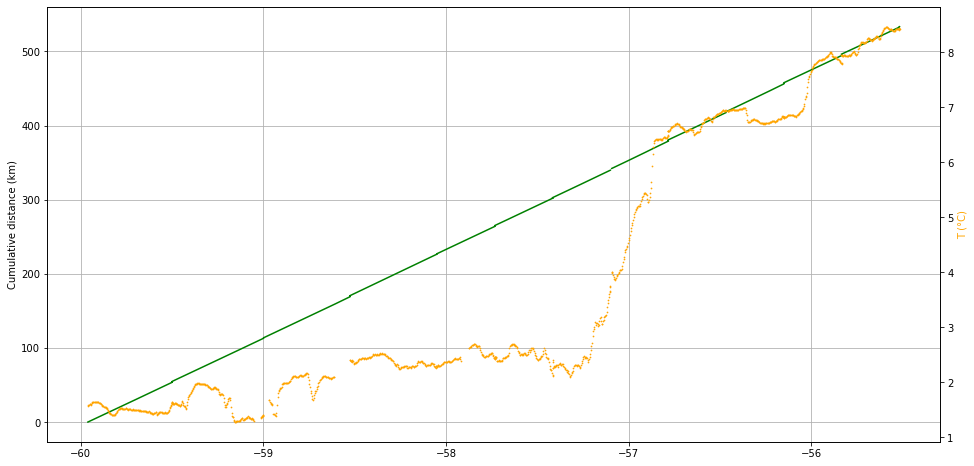

In [56]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot = df_2
ax.plot(df_plot.lat, df_plot['distance_cum']/1000, c='green')
ax.set_ylabel('Cumulative distance (km)')
ax1 = ax.twinx()
ax1.scatter(df_plot.lat, df_plot['TMESSG01'], s=0.5, c='orange')
ax1.set(xlabel='Time', ylabel='T (°C)')
ax.grid(axis='both', which='both')
ax1.yaxis.label.set_color('orange')

## Density calculation

In [57]:
ds

<xarray.Dataset>
Dimensions:                 (time: 41277)
Coordinates:
    lat                     (time) float64 -51.72 -51.72 -51.72 ... -54.6 -54.59
    lon                     (time) float64 -57.65 -57.65 ... -58.36 -58.37
    depth                   (time) float32 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
  * time                    (time) datetime64[ns] 2017-11-08 ... 2017-12-06T1...
Data variables: (12/25)
    SDN_CRUISE              |S80 b'JR17001 (ORCHESTRA)'
    crs                     int32 0
    SDN_EDMO_CODE           int32 43
    SDN_STATION             |S80 b'JR17001_PROD_SURF'
    SDN_LOCAL_CDI_ID        |S80 b'1903933'
    SDN_BOT_DEPTH           (time) float32 nan nan nan nan ... nan nan nan nan
    ...                      ...
    TEMPHU01_SEADATANET_QC  (time) float32 nan nan nan nan ... nan nan nan nan
    TEMPHU01                (time) float32 nan nan nan nan ... nan nan nan nan
    TEMPHU02_SEADATANET_QC  (time) float32 nan nan nan nan ... nan nan nan nan
    TEMPHU02                (time) float32 nan nan nan nan ... nan nan nan nan
    TMESSG01_SEADATANET_QC  (time) float32 nan nan nan nan ... nan nan nan nan
    TMESSG01                (time) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    date_update:  2020-07-31T01:05:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

### df_1

In [58]:
df_1['SA'] = gsw.SA_from_SP(df_1['PSALSG01'].values, 0, df_1['lon'].values, df_1['lat'].values)
df_1['CT'] = gsw.CT_from_t(df_1['SA'].values, df_1['TMESSG01'].values, 0)
df_1['rho'] = gsw.rho(df_1['SA'].values, df_1['CT'].values, 0)

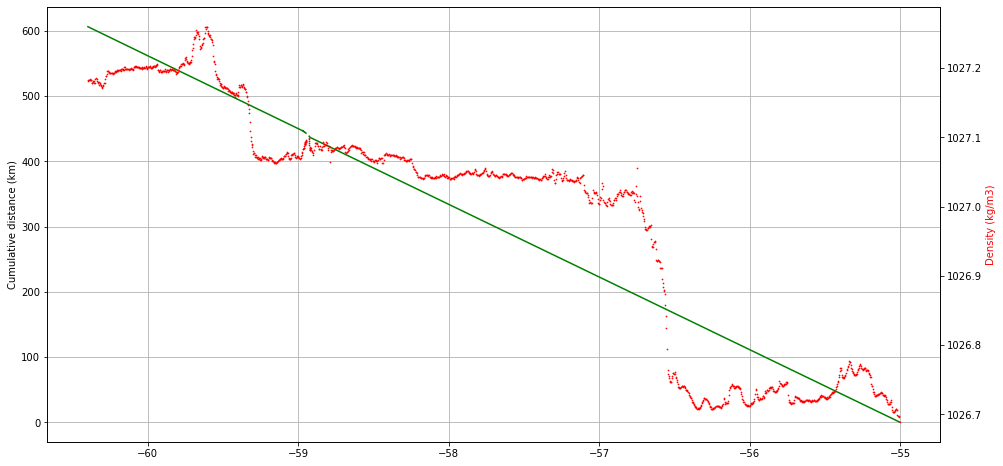

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot = df_1
ax.plot(df_plot['lat'], df_plot['distance_cum']/1000, c='green')
ax.set_ylabel('Cumulative distance (km)')
ax1 = ax.twinx()
ax1.scatter(df_plot['lat'], df_plot['rho'], s=0.5, c='red')
ax1.set(xlabel='Time', ylabel='Density (kg/m3)')
ax.grid(axis='both', which='both')
ax1.yaxis.label.set_color('red')

### df_2

In [60]:
df_2['SA'] = gsw.SA_from_SP(df_2['PSALSG01'].values, 0, df_2['lon'].values, df_2['lat'].values)
df_2['CT'] = gsw.CT_from_t(df_2['SA'].values, df_2['TMESSG01'].values, 0)
df_2['rho'] = gsw.rho(df_2['SA'].values, df_2['CT'].values, 0)

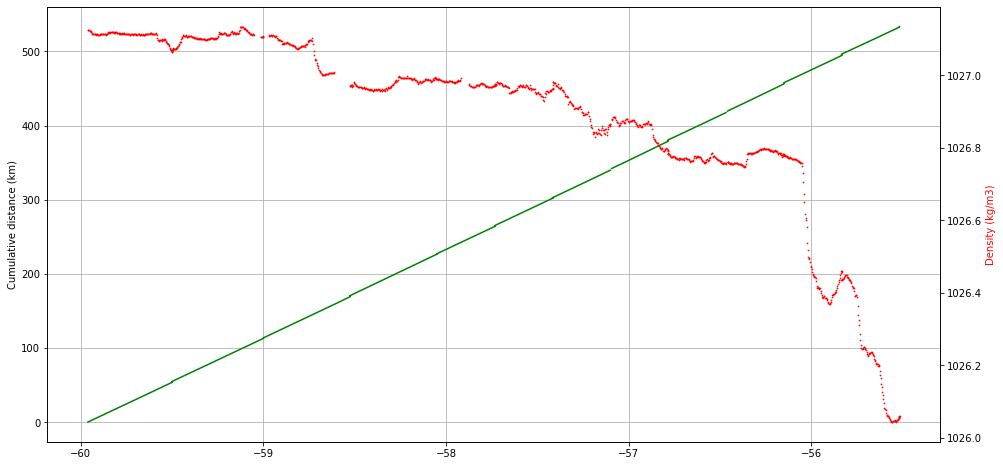

In [61]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot = df_2
ax.plot(df_plot['lat'], df_plot['distance_cum']/1000, c='green')
ax.set_ylabel('Cumulative distance (km)')
ax1 = ax.twinx()
ax1.scatter(df_plot['lat'], df_plot['rho'], s=0.5, c='red')
ax1.set(xlabel='Time', ylabel='Density (kg/m3)')
ax.grid(axis='both', which='both')
ax1.yaxis.label.set_color('red')

## Lateral density scale histogram

In [62]:
def downsample(df, gridsize):
    from scipy.interpolate import griddata
    #create the distance grid
    distance_grid = np.arange(0, float(np.max(df.distance_cum)), gridsize)
    
    #we need to create a mask so the nans stay nans after gridding and are not interpolated
    df_mask = df.notna()[['rho', 'distance_cum']]
    df_mask['distance_cum'] = df['distance_cum']
    grid_mask = griddata(df_mask['distance_cum'].values, df_mask['rho'].values, distance_grid, method='linear')

    rho = griddata(df['distance_cum'].values, df['rho'].values, distance_grid, method='linear')*grid_mask
    lat = griddata(df['distance_cum'].values, df['lat'].values, distance_grid, method='linear')
    df_aux = pd.DataFrame(rho, columns=['rho'], index=distance_grid)
    df_aux['lat'] = lat
    return df_aux

def method_1(df):
    g=9.8
    rho_0 = 1025
    df_500 = downsample(df,500)
    df_500['bx_500'] = (-g/rho_0)*df_500['rho'].diff()/1000
    df_500['bx_1000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=2).mean()
    df_500['bx_2000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=4).mean()
    df_500['bx_5000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=10).mean()
    df_500['bx_10000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=20).mean()
    return df_500

def method_3(df):
    g=9.8
    rho_0 = 1025
    df_500 =  downsample(df, 500)
    df_500['rho_1000'] = df_500['rho'].rolling(2).mean()
    df_500['rho_2000'] = df_500['rho'].rolling(4).mean()
    df_500['rho_5000'] = df_500['rho'].rolling(10).mean()
    df_500['rho_10000'] = df_500['rho'].rolling(20).mean()
    df_500['bx_500'] = (-g/rho_0)*df_500['rho'].diff()/1000
    df_500['bx_1000'] = (-g/rho_0)*df_500['rho_1000'].diff()/1000
    df_500['bx_2000'] = (-g/rho_0)*df_500['rho_2000'].diff()/1000
    df_500['bx_5000'] = (-g/rho_0)*df_500['rho_5000'].diff()/1000
    df_500['bx_10000'] = (-g/rho_0)*df_500['rho_10000'].diff()/1000
    return df_500

### df_1

In [63]:
# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

In [64]:
distance_cum_1 = np.insert(np.cumsum(distance_sel_1), 0, 0)
df_1['time'] = df_1.index
df_1['distance_cum'] = distance_cum_1
df_1 = df_1.set_index(df_1['distance_cum'])
df_1

,lat,lon,ATTNDR01_SEADATANET_QC,CNDCSG01_SEADATANET_QC,CNDCSG01,PSALSG01,PSALSU01,TEMPHU01_SEADATANET_QC,TEMPHU01,TEMPHU02_SEADATANET_QC,TEMPHU02,TMESSG01,distance_cum,vel,SA,CT,rho,time
distance_cum,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2017-11-09 17:38:59.998624
393.622082,-55.005959,-57.872765,49.0,49.0,3.393960,33.989899,33.993000,49.0,5.80505,49.0,5.82615,6.52085,393.622082,6.560368,34.150875,6.526892,1026.689067,2017-11-09 17:39:59.999424
782.473587,-55.009449,-57.872391,49.0,49.0,3.393265,33.995998,33.999100,49.0,5.79900,49.0,5.82140,6.50705,782.473587,6.480858,34.157004,6.513002,1026.695690,2017-11-09 17:41:00.000224
1155.076367,-55.012787,-57.871876,49.0,49.0,3.393100,33.997849,34.000950,49.0,5.80315,49.0,5.82845,6.50340,1155.076367,6.210046,34.158864,6.509325,1026.697628,2017-11-09 17:42:00.001024
1537.103560,-55.016209,-57.871338,49.0,49.0,3.392930,33.997799,34.000900,49.0,5.80395,49.0,5.84110,6.50115,1537.103560,6.367120,34.158815,6.507074,1026.697885,2017-11-09 17:43:00.001824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604932.085310,-60.383293,-57.226204,49.0,49.0,2.847620,33.873600,33.876701,49.0,-0.61215,49.0,-0.60675,0.34185,604932.085310,6.733360,34.036304,0.346763,1027.182581,2017-11-10 19:52:00.002176
605337.010781,-60.386902,-57.225216,49.0,49.0,2.843395,33.872051,33.875149,49.0,-0.62490,49.0,-0.61975,0.29105,605337.010781,6.863144,34.034750,0.295953,1027.184142,2017-11-10 19:52:59.997824
605742.133880,-60.390518,-57.224319,49.0,49.0,2.841680,33.869099,33.872200,49.0,-0.63055,49.0,-0.62455,0.27420,605742.133880,6.752052,34.031786,0.279111,1027.182688,2017-11-10 19:53:59.998624


#### method 3

In [65]:
df_1_500 = method_3(df_1)

In [66]:
df_1_500

,rho,lat,rho_1000,rho_2000,rho_5000,rho_10000,bx_500,bx_1000,bx_2000,bx_5000,bx_10000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500.0,1026.690878,-55.006913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,1026.696821,-55.011398,1026.693850,NaN,NaN,NaN,-5.682078e-08,NaN,NaN,NaN,NaN
1500.0,1026.697860,-55.015876,1026.697341,NaN,NaN,NaN,-9.930593e-09,-3.337568e-08,NaN,NaN,NaN
2000.0,1026.700728,-55.020361,1026.699294,1026.696572,NaN,NaN,-2.741909e-08,-1.867484e-08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
604500.0,1027.182701,-60.379442,1027.182146,1027.181125,1027.181718,1027.179047,-1.059900e-08,-1.835631e-08,-5.552159e-09,-2.038793e-09,-2.106897e-09
605000.0,1027.182843,-60.383898,1027.182772,1027.181499,1027.181612,1027.179397,-1.358608e-09,-5.978805e-09,-3.576598e-09,1.017208e-09,-3.342994e-09
605500.0,1027.183557,-60.388357,1027.183200,1027.182673,1027.181407,1027.179898,-6.827864e-09,-4.093236e-09,-1.122477e-08,1.958770e-09,-4.787334e-09
606000.0,1027.182230,-60.392821,1027.182893,1027.182833,1027.181287,1027.180393,1.269168e-08,2.931907e-09,-1.523449e-09,1.141124e-09,-4.733206e-09


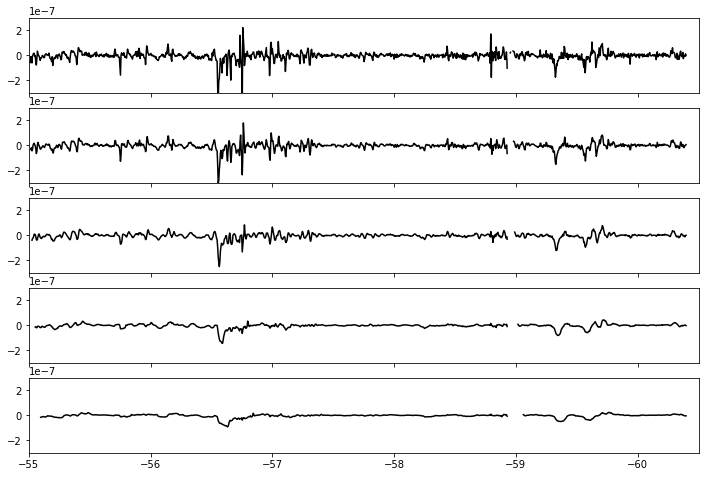

In [67]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, sharex=True, figsize=(12,8))
df = df_1_500
a = df['bx_500']
b = df['bx_1000']
c = df['bx_2000']
d = df['bx_5000']
e = df['bx_10000']
vars = [a, b, c, d, e,]
axes = [ax0, ax1, ax2, ax3, ax4]
for i in range(len(vars)):
    axes[i].plot(df['lat'], vars[i], color='black')
    axes[i].set_ylim((-3E-7,3E-7))
    axes[i].set_xlim((-55,-60.5))

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


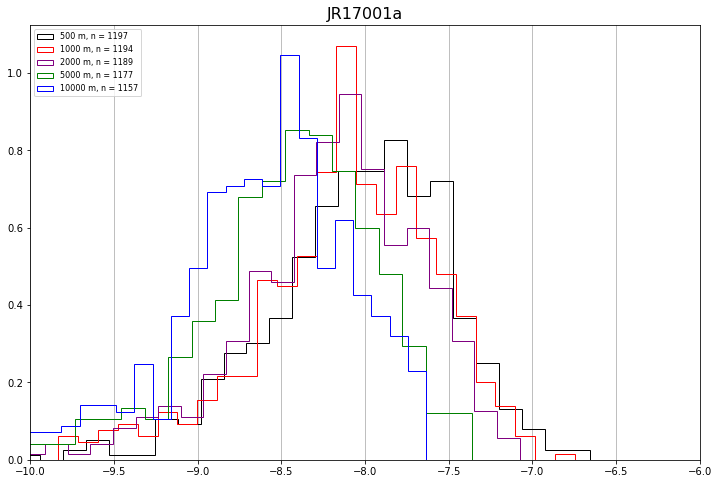

In [83]:
fig, ax = plt.subplots(figsize=(12,8))
df = df_1_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
aux = [a, b, c, d, e]
label = ['500 m, n = ' + str(len(a)), '1000 m, n = ' + str(len(b)), '2000 m, n = ' + str(len(c)), '5000 m, n = ' + str(len(d)), '10000 m, n = ' + str(len(e))]
colors = ['black', 'red', 'purple', 'green', 'blue', 'orange']
for i in range(len(aux)):
    ax.hist(np.log10(aux[i]), histtype='step', density=True, bins=30, label=label[i], color=colors[i])
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(-10,-6)
ax.grid(axis='x')
# ax.set_xticks([-8,-7,-6,-5,-4])
ax.set_title('JR17001a', fontsize=16)
plt.savefig('results/analysis/25-02-22/hist_JR17001a.png', format='png')

In [69]:
from scipy.stats import kstest
df = df_1_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
vars_name = ['a', 'b', 'c', 'd', 'e']
vars = [a, b, c, d, e]
for i in range(len(vars)):
    print('e and ' + vars_name[i] + ': ' + str(kstest(e, vars[i])))

e and a: KstestResult(statistic=0.21238850511470264, pvalue=9.385602424146408e-24)
e and b: KstestResult(statistic=0.19260520406700746, pvalue=3.4416913763379853e-15)
e and c: KstestResult(statistic=0.15824690896746538, pvalue=2.681188604469753e-13)
e and d: KstestResult(statistic=0.06848931809553463, pvalue=0.00784674220344328)
e and e: KstestResult(statistic=0.0, pvalue=1.0)


In [70]:
df_1_500.to_csv('data/03_processed/cruises/JR17001a')

### df_2

In [71]:
# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

In [72]:
distance_cum_2 = np.insert(np.cumsum(distance_sel_2), 0, 0)
df_2['time'] = df_2.index
df_2['distance_cum'] = distance_cum_2
df_2 = df_2.set_index(df_2['distance_cum'])
df_2

,lat,lon,ATTNDR01_SEADATANET_QC,CNDCSG01_SEADATANET_QC,CNDCSG01,PSALSG01,PSALSU01,TEMPHU01_SEADATANET_QC,TEMPHU01,TEMPHU02_SEADATANET_QC,TEMPHU02,TMESSG01,distance_cum,vel,SA,CT,rho,time
distance_cum,,,,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2017-12-03 00:00:00.000000
354.519984,-59.960789,-55.270668,49.0,49.0,2.954320,33.899849,33.902950,49.0,0.71590,49.0,0.72765,1.57865,354.519984,5.908666,34.062840,1.583795,1027.124919,2017-12-03 00:01:00.000000
709.538263,-59.957706,-55.272331,49.0,49.0,2.954850,33.899151,33.902248,49.0,0.71705,49.0,0.72795,1.58500,709.538263,5.916971,34.062136,1.590151,1027.123901,2017-12-03 00:02:00.000000
1056.531822,-59.954685,-55.273891,49.0,49.0,2.955225,33.900150,33.903252,49.0,0.71730,49.0,0.72650,1.58890,1056.531822,5.783226,34.063139,1.594046,1027.124420,2017-12-03 00:03:00.000000
1407.400422,-59.951633,-55.275494,49.0,49.0,2.955855,33.898602,33.901699,49.0,0.72330,49.0,0.73575,1.59805,1407.400422,5.847810,34.061580,1.603209,1027.122517,2017-12-03 00:04:00.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534210.183947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534210.183947,NaN,NaN,NaN,NaN,2017-12-05 16:56:00.000224
534211.947321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534211.947321,NaN,NaN,NaN,NaN,2017-12-05 16:57:00.001024
534215.416359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534215.416359,NaN,NaN,NaN,NaN,2017-12-05 16:58:00.001824


#### method 3

In [73]:
df_2_500 = method_3(df_2)

In [74]:
df_2_500

,rho,lat,rho_1000,rho_2000,rho_5000,rho_10000,bx_500,bx_1000,bx_2000,bx_5000,bx_10000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500.0,1027.124502,-59.959526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,1027.124336,-59.955177,1027.124419,NaN,NaN,NaN,1.591852e-09,NaN,NaN,NaN,NaN
1500.0,1027.122535,-59.950830,1027.123435,NaN,NaN,NaN,1.721987e-08,9.405863e-09,NaN,NaN,NaN
2000.0,1027.122139,-59.946494,1027.122337,1027.123378,NaN,NaN,3.783439e-09,1.050166e-08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
532000.0,1026.050132,-55.523875,1026.050405,1026.048546,1026.046961,1026.058988,5.234887e-09,-7.023121e-09,-6.847875e-09,-2.120871e-09,3.709740e-08
532500.0,1026.057180,-55.519954,1026.053656,1026.051663,1026.048166,1026.056191,-6.739342e-08,-3.107927e-08,-2.980373e-08,-1.152407e-08,2.674036e-08
533000.0,1026.055336,-55.518232,1026.056258,1026.053332,1026.049214,1026.054174,1.763300e-08,-2.488021e-08,-1.595166e-08,-1.001894e-08,1.928206e-08
533500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


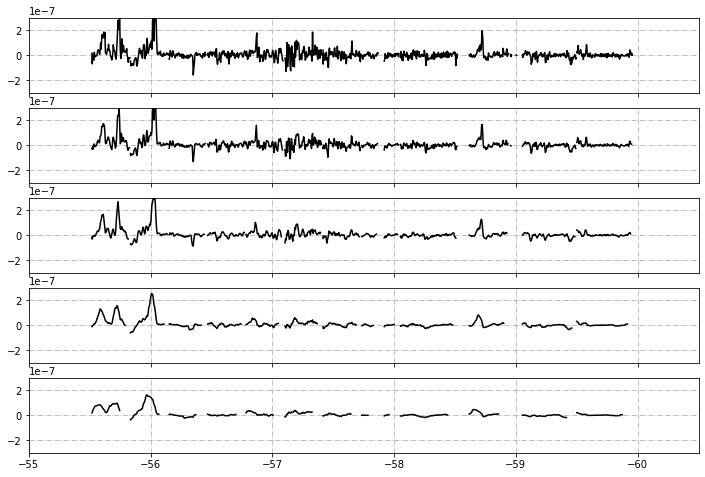

In [75]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, sharex=True, figsize=(12,8))
df = df_2_500
a = df['bx_500']
b = df['bx_1000']
c = df['bx_2000']
d = df['bx_5000']
e = df['bx_10000']
vars = [a, b, c, d, e,]
axes = [ax0, ax1, ax2, ax3, ax4]
for i in range(len(vars)):
    axes[i].plot(df['lat'], vars[i], color='black')
    axes[i].set_ylim((-3E-7,3E-7))
    axes[i].set_xlim((-55,-60.5))
    axes[i].grid(linestyle='-.')

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


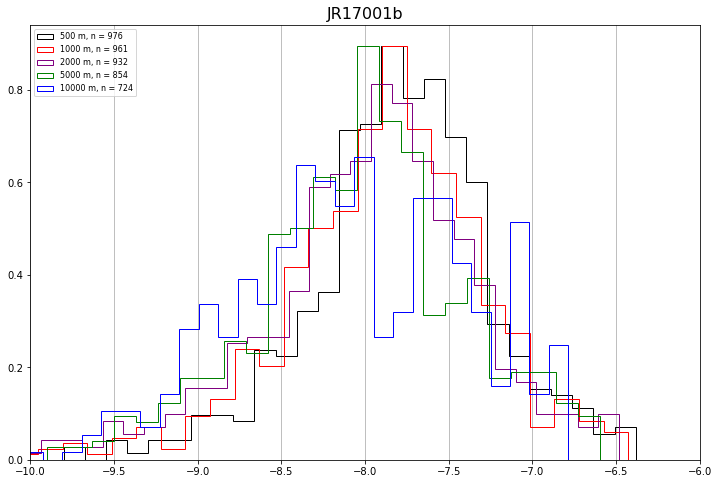

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
df = df_2_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
aux = [a, b, c, d, e]
label = ['500 m, n = ' + str(len(a)), '1000 m, n = ' + str(len(b)), '2000 m, n = ' + str(len(c)), '5000 m, n = ' + str(len(d)), '10000 m, n = ' + str(len(e))]
colors = ['black', 'red', 'purple', 'green', 'blue', 'orange']
for i in range(len(aux)):
    ax.hist(np.log10(aux[i]), histtype='step', density=True, bins=30, label=label[i], color=colors[i])
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(-10,-6)
ax.grid(axis='x')
# ax.set_xticks([-8,-7,-6,-5,-4])
ax.set_title('JR17001b', fontsize=16)
plt.savefig('results/analysis/25-02-22/hist_JR17001b.png', format='png')

In [77]:
from scipy.stats import kstest
df = df_2_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
vars_name = ['a', 'b', 'c', 'd', 'e']
vars = [a, b, c, d, e]
for i in range(len(vars)):
    print('e and ' + vars_name[i] + ': ' + str(kstest(e, vars[i])))

e and a: KstestResult(statistic=0.19737229417625216, pvalue=1.021405182655144e-14)
e and b: KstestResult(statistic=0.14679259059106248, pvalue=3.117315350298355e-08)
e and c: KstestResult(statistic=0.10916937376994759, pvalue=0.00010864985205094602)
e and d: KstestResult(statistic=0.058974989325501055, pvalue=0.12437261492365037)
e and e: KstestResult(statistic=0.0, pvalue=1.0)


In [78]:
df_2_500.to_csv('data/03_processed/cruises/JR17001b')